# Parent Child Political Correlation
Studying the correlation between parent's political affiliations and involvements and the political affiliations and involvement of their children.

Import some packages we will use later:

In [1]:
import pandas as pd
import numpy as np
import os
from empiricaldist import Pmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Unpack the tar file if the data file is not already uncompressed on this machine:

In [2]:
if not os.path.exists('anes_timeseries_cdf_rawdata.txt'):
    !tar -xvf data.tar.bz2

Import the data and save as dataframe:

In [3]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

## Load & Prepare the Data

In [4]:
anes = pd.read_csv('anes_timeseries_cdf_rawdata.txt', delimiter=',', low_memory=False, na_values=[' ','  '])
anes

,Version,VCF0004,VCF0006,VCF0006a,VCF0009x,VCF0010x,VCF0011x,VCF0009y,VCF0010y,VCF0011y,...,VCF9272,VCF9273,VCF9274,VCF9275,VCF9277,VCF9278,VCF9279,VCF9280,VCF9281,VCF9282
0,ANES_CDF_VERSION:2019-Sep-10,1948,1001,19481001,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANES_CDF_VERSION:2019-Sep-10,1948,1002,19481002,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ANES_CDF_VERSION:2019-Sep-10,1948,1003,19481003,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ANES_CDF_VERSION:2019-Sep-10,1948,1004,19481004,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ANES_CDF_VERSION:2019-Sep-10,1948,1005,19481005,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59939,ANES_CDF_VERSION:2019-Sep-10,2016,5086,20165086,0.0,0.0,0.0,0.818,0.818,0.818,...,2.0,1.0,NaN,3.0,1.0,2.0,1.0,1.0,1.0,1.0
59940,ANES_CDF_VERSION:2019-Sep-10,2016,5087,20165087,0.0,0.0,0.0,1.280,1.280,1.280,...,3.0,6.0,NaN,2.0,-9.0,-9.0,1.0,2.0,1.0,1.0
59941,ANES_CDF_VERSION:2019-Sep-10,2016,5088,20165088,0.0,0.0,0.0,3.788,3.788,3.788,...,1.0,5.0,NaN,2.0,-9.0,-9.0,1.0,2.0,1.0,1.0
59942,ANES_CDF_VERSION:2019-Sep-10,2016,5089,20165089,0.0,0.0,0.0,1.162,1.162,1.162,...,2.0,2.0,NaN,3.0,2.0,2.0,1.0,2.0,1.0,1.0


Load and clean general statistics (gender, race, socio economic status, age, education):

In [16]:
gender = anes['VCF0104']
gender.name='gender'
values(gender)

0      144
1    26849
2    32940
3       11
Name: gender, dtype: int64

And clean the gender variable. 0 corresponds to NA and 3 is other (it pains me to remove this, but the sample size is too small). 1 corresponds to male and 2 to female.

In [17]:
remap = {1: 'male',
         2: 'female',
         0: np.nan,
         3: np.nan}
gender = gender.replace(remap)
values(gender)

female    32940
male      26849
Name: gender, dtype: int64

In [18]:
race = anes['VCF0105b'].replace([9, 0], np.nan) # 9 is NA/missing, 0 is missing
race.name='race'
remap = {1: 'white',
         2: 'black',
         3: 'hispanic',
         4: 'other'}
race = race.replace(remap)
values(race)

black        6906
hispanic     3942
other        1466
white       46035
Name: race, dtype: int64

In [19]:
income = anes['VCF0114'].replace(0, np.nan) # 0 is don't know or NA
remap = {1: 'lower',
         2: 'lowerMiddle',
         3: 'middle',
         4: 'upperMiddle',
         5: 'upper'}
income = income.replace(remap)
income.name='income'
values(income)

lower           9474
lowerMiddle     9064
middle         17868
upper           2835
upperMiddle    15254
Name: income, dtype: int64

Here is the translation guide from income percent to class:

Percentile | Class Label
--- | ---
0 to 16 percentile | Lower
17 to 33 percentile | Lower Middle
34 to 67 percentile | Middle
68 to 95 percentile | Upper Middle
96 to 100 percentile | Upper

In [20]:
age = anes['VCF0102'].replace(0, np.nan) # 0 is NA or Don't Know
age.name='age'
remap = {1: '17-24',
         2: '25-34',
         3: '35-44',
         4: '45-54',
         5: '55-64',
         6: '65-74',
         7: '75-99'}
age = age.replace(remap)
values(age)

17-24     5630
25-34    12241
35-44    11838
45-54    10106
55-64     8970
65-74     6787
75-99     3818
Name: age, dtype: int64

I cut the age off at 89 due to inconsistencies across the year with what values above 90 meant. Some years 90 meant 90 and above, some years 91 meant  91 and above and 90 meant 90, and so on - up to 99. 

In [21]:
educ = anes['VCF0110'].replace(0, np.nan) # 0 is DK, NA (used 4 category for easy of data, there are also 6 and 7 category versions)
remap = {1: 'Grade School',
         2: 'High School',
         3: 'Some College',
         4: 'College Degree'}
educ = educ.replace(remap)
educ.name='educ'
values(educ)

College Degree    12011
Grade School       8098
High School       25884
Some College      13360
Name: educ, dtype: int64

1. 8 grades or less ('grade school')
2. 9-12 grades ('high school'), no diploma/equivalency
3. 12 grades, diploma or equivalency
4. 12 grades, diploma or equivalency plus non-academic training
5. Some college, no degree; junior/community college level degree (AA degree)
6. BA level degrees
7. Advanced degrees incl. LLB

Load and clean the variables for the respondent's parent's political affiliation:

In [22]:
fatherPol = anes['VCF0306'].replace([0, 4, 9], np.nan)
# 0, 4, and 9 represent "NA", "Other" and  "Don't know" respectively
remap = {1: 'Democrat',
         2: 'Independent',
         3: 'Republican'}
fatherPol = fatherPol.replace(remap)
fatherPol.name='DadPol'
values(fatherPol)

Democrat       9747
Independent    1355
Republican     5351
Name: DadPol, dtype: int64

In [23]:
motherPol = anes['VCF0307'].replace([0, 4, 9], np.nan)
remap = {1: 'Democrat',
         2: 'Independent',
         3: 'Republican'}
motherPol = motherPol.replace(remap)
motherPol.name='MomPol'
values(motherPol)

Democrat       9337
Independent    1416
Republican     5061
Name: MomPol, dtype: int64

Here is a seven point political affilation scale in case we need it later:

Where:

0. NA
1. Strong Democrat
2. Weak Democrat
3. Independent -Democrat
4. Independent -Independent
5. Independent -Republican
6. Weak Republican
7. Strong Republican

In [24]:
pol7 = anes['VCF0301'].replace(0, np.nan)
pol7.name='pol7'
values(pol7)

1.0    11695
2.0    11820
3.0     6886
4.0     6988
5.0     5882
6.0     7921
7.0     7075
Name: pol7, dtype: int64

And let's create a simple three point scale, just like in the variable booklet (including leaners):

In [25]:
remap = {1: 1,
         2: 1,
         3: 1,
         4: 2,
         5: 3,
         6: 3,
         7: 3}
pol = pol7.replace(remap)
pol.name='pol'
values(pol)

1.0    30401
2.0     6988
3.0    20878
Name: pol, dtype: int64

Finally load the year time series and construct a new dataframe with the cleaned data.

In [26]:
year = anes['VCF0004']
year.name='Year'
year

0        1948
1        1948
2        1948
3        1948
4        1948
         ... 
59939    2016
59940    2016
59941    2016
59942    2016
59943    2016
Name: Year, Length: 59944, dtype: int64

# Data Verification
To make sure all our variables loaded correctly, let's verify our data by testing a random year for each one. To do this, I used the [individual year](https://electionstudies.org/data-center/) time series links from the ANES site.

**Gender**

For the year 1992, we expect:
1. 1327 female respondents
2. 1158 male respondents

In [77]:
values(gender[(year == 1992)])

female    1327
male      1158
Name: gender, dtype: int64

**Race**

For the year 1970, we expect: 
1. 1340 white
2. 145 black
3. 14 hispanic
4. 8 other

In [80]:
values(race[(year == 1970)])

black        145
hispanic      14
other          8
white       1340
Name: race, dtype: int64

**Income**

Due to the inconsistent value reporting for the income grouping, it was not possible to accurately validate my income data.


**Age**

For the year 2016, we expect:
1. 17-24 -> 328
2. 25-34 -> 710
3. 35-44 -> 655
4. 45-54 -> 688
5. 55-64 -> 817
6. 65-74 -> 623
7. 75-99 -> 328

In [85]:
values(age[(year == 2016)])

17-24    328
25-34    710
35-44    655
45-54    688
55-64    817
65-74    623
75-99    328
Name: age, dtype: int64

**Education**

For the year 1988, we expect:
1. Grade School: 199
2. High School: 957
3. Some College: 450
4. College Degree: 397

In [89]:
values(educ[(year == 1988)])

College Degree    397
Grade School      199
High School       957
Some College      450
Name: educ, dtype: int64

**Father Political Affiliation**

For the year 1972, I expect:
1. 1282 Democrats
2. 166 Independetns
3. 690 Republicans

In [90]:
values(fatherPol[(year == 1972)])

Democrat       1282
Independent     166
Republican      690
Name: DadPol, dtype: int64

**Mother Political Affiliation**

For the year 1972, I expect:
1. 1277 Democrats
2. 178 Independents
3. 654 Republicans

In [92]:
values(motherPol[(year == 1972)])

Democrat       1277
Independent     178
Republican      654
Name: MomPol, dtype: int64

**Political Affiliation**

Verify political affilitaon for 1980, there should be: 

1. 286 Strong Democrats
2. 372 Weak Democrats
3. 184 Independent - Democrats
4. 243 Independent - Independent
5. 165 Independent - Republican
6. 225 Weak Republican
7. 137 Strong Republican

In [104]:
column = data['pol7']
one_year = (data['year'] == 1980)
values(column[one_year])

1.0    286
2.0    371
3.0    184
4.0    243
5.0    166
6.0    225
7.0    137
Name: pol7, dtype: int64

These values do not seem to be exact, though they are incredibly close. I am not sure what is causing this. So in the name of time, let's keep going.

The data looks pretty good, so I think I will be in good shape.

Finally let's construct a dataframe to keep all our data organized for when we do analysis:

In [109]:
d = {'year': year, 'gender': gender, 'race': race, 'income': income, 'age': age, 'educ':educ, 
     'fatherPol':fatherPol, 'motherPol': motherPol, 'pol': pol, 'pol7': pol7, 'weight':anes['VCF0009x']}
data = pd.DataFrame(data=d)
data

,year,gender,race,income,age,educ,fatherPol,motherPol,pol,pol7,weight
0,1948,male,white,middle,35-44,Grade School,NaN,NaN,NaN,NaN,1.0
1,1948,female,white,upper,35-44,High School,NaN,NaN,NaN,NaN,1.0
2,1948,female,white,upperMiddle,25-34,High School,NaN,NaN,NaN,NaN,1.0
3,1948,female,white,upper,35-44,Some College,NaN,NaN,NaN,NaN,1.0
4,1948,male,white,upperMiddle,25-34,Some College,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
59939,2016,female,white,upperMiddle,35-44,College Degree,NaN,NaN,1.0,1.0,0.0
59940,2016,male,white,NaN,75-99,High School,NaN,NaN,1.0,1.0,0.0
59941,2016,male,white,lower,25-34,High School,NaN,NaN,1.0,2.0,0.0
59942,2016,female,black,lower,35-44,Some College,NaN,NaN,1.0,1.0,0.0


## Resampling and Weighting

In [110]:
def resample_rows_weighted(df, column):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    sample = df.sample(n=len(df), replace=True, weights=weights)
    return sample

In [111]:
def resample_by_year(df, column):
    """Resample rows within each year.

    df: DataFrame
    column: string name of weight variable

    returns DataFrame
    """
    grouped = df.groupby('year') # group by year
    samples = [resample_rows_weighted(group, column)
               for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

In [116]:
sample = resample_by_year(data, 'weight')
sample

,year,gender,race,income,age,educ,fatherPol,motherPol,pol,pol7,weight
0,1948,female,white,upper,35-44,High School,NaN,NaN,NaN,NaN,1.000
1,1948,female,white,middle,25-34,Grade School,NaN,NaN,NaN,NaN,1.000
2,1948,male,white,middle,35-44,High School,NaN,NaN,NaN,NaN,1.000
3,1948,female,white,upperMiddle,25-34,High School,NaN,NaN,NaN,NaN,1.000
4,1948,male,black,middle,45-54,Some College,NaN,NaN,NaN,NaN,1.000
...,...,...,...,...,...,...,...,...,...,...,...
59939,2016,male,white,middle,45-54,College Degree,NaN,NaN,1.0,1.0,0.509
59940,2016,female,other,lower,25-34,High School,NaN,NaN,2.0,4.0,1.882
59941,2016,male,white,lowerMiddle,25-34,Some College,NaN,NaN,1.0,3.0,3.156
59942,2016,female,white,upperMiddle,17-24,College Degree,NaN,NaN,1.0,1.0,1.672


# Analysis
To start, just looking at how individual variables correlate with political affilation:
* Gender
* Race and Ethnicity
* Socio economic status
* Age
* Mother's political affiliation
* Father's political affiliation

First some functions to help with plotting:

In [117]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

In [118]:
import itertools
def annotateBars(pmf, xOffset, y, barCount, fontsize):
    """Annotate bars with their values.
    
    pmf: pmf
    xOffset: x offset to calculate x position
    y: y position
    barCount: number of bars per point
    fontsize: fontsize in pixels
    """
    xScale = pmf.qs[0]
    fontsize = fontsize
#     fontsize = (20/barCount)*(10/len(pmf)) # account for number of bars and the width of the plot (based on points on scale)
#     if fontsize > 24:
#         fontsize = 24
    
    for (x, val) in zip(pmf.qs, pmf.values):
        val = round(val, 2)
        x = x + xOffset - xScale/10 # center on bar
        plt.text(x, y, str(val).strip('0'), fontstyle='oblique', fontweight=600, fontsize=fontsize, rotation=45)

In [123]:
def pmfComparison(data, fontsize=15, xOffset=0, yOffset=0, **options):
    """Create bar plot via pmf to compare data.
    
    data: list of pd.Series
    fontsize: fontsize for annotate text
    xOffset: x offset for annotate text
    yOffset: y offset for annotate text
    """
    labels = [] # series labels
    pmfList = [] # list of pmfs for adding labels
    width = .8/len(data) # width of bar
    plotMin = 1000 # minimum value in plot
    
    for i, series in enumerate(data):
        offset = width*i - width*len(data)/2 # offset derived from order bar is in reference to others       
        pmf = Pmf.from_seq(series)
        pmfList.append((pmf, offset)) # store pmf
        if pmf.min() < plotMin:
            plotMin = pmf.min() # store new plot minimum
            
    for i, (pmf, offset) in enumerate(pmfList): # plot and label each pmf
        if i == int(len(data)/2): # if at half way, do any options
            plt.bar(pmf.qs+offset, pmf, width=width, align='edge', alpha=0.7, **options) # plot
        else: 
            plt.bar(pmf.qs+offset, pmf, width=width, align='edge', alpha=0.7) # plot
        annotateBars(pmf, offset + xOffset, plotMin/4 + yOffset, len(data), fontsize) # annotate
        labels.append(pmf.name) # store label
        
    plt.legend(labels) # label

## Gender
Let's grab the political affiliation for men and women:

In [124]:
female = data[data['gender']=='female']['pol7']
female.name = 'Women'
male = data[data['gender']=='male']['pol7']
male.name = 'Men'

And visualize the political spread of men and women:

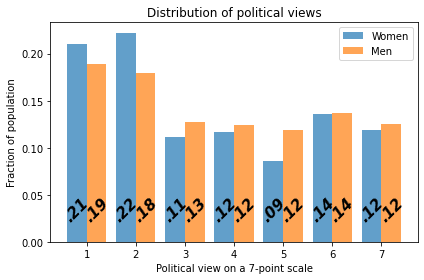

In [125]:
pmfComparison([female, male])
decorate(xlabel='Political view on a 7-point scale',
         ylabel='Fraction of population', 
         title='Distribution of political views')

Just as a refresher, 4 is the center, 1 is the most democrat, and 7 is the most republican:

1. Strong Democrat
2. Weak Democrat
3. Independent -Democrat
4. Independent -Independent
5. Independent -Republican
6. Weak Republican
7. Strong Republican



Women are more likely to be be at the far left end of the political spectrum by a few percentage points, with men more likely to be further to the right. It looks like men may be more moderate in general than women. There is a very small difference between the number of republican men and than women (though there are still more), while there are significantly more democrat women than men.

Now let's reduce the number of categories to see if we can see anything else. We will be using the pol variable which groups into 3 categories (1-3 as democrats, 5-7 as republicans, and 4 as independents).

In [126]:
female2 = data[data['gender']=='female']['pol']
female2.name = 'Women'
male2 = data[data['gender']=='male']['pol']
male2.name = 'Men'

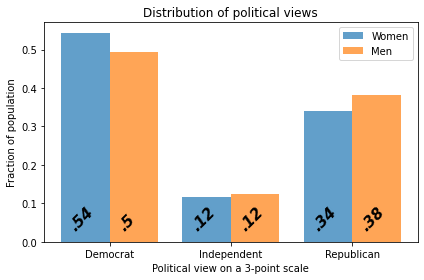

In [127]:
pmfComparison([female2, male2], tick_label = ['Democrat', 'Independent', 'Republican'], xOffset=.15)
decorate(xlabel='Political view on a 3-point scale',ylabel='Fraction of population', title='Distribution of political views')

Now it is quite a bit easier to see that women tend to lean democrat, and men tend to lean republican. There are about 4 percentage points more women democrats than men democrats. There are about 4 percentage points more men republicans than women republicans.

Now let's just look at the people who fully identify with a political party. We will use our seven point scale from earlier to create a new three point scale. 1-2 will be democrats, 6-7 republicans, and 3-5 independents.

In [128]:
remap = {1: 1, 2: 1, 
         3: 2, 4: 2, 5: 2, 
         6: 3, 7: 3}

female3 = female.replace(remap)
male3 = male.replace(remap)

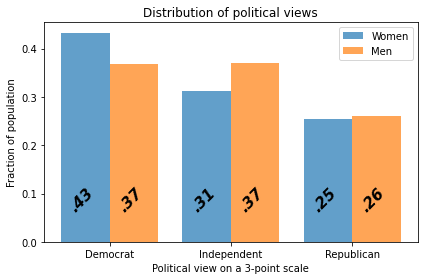

In [129]:
pmfComparison([female3, male3], tick_label = ['Democrat', 'Independent', 'Republican'], xOffset=.15)
decorate(xlabel='Political view on a 3-point scale',ylabel='Fraction of population', title='Distribution of political views')

When only looking at people who fully identitfy with a political party, we can see the tendency for women to lean harder democrat than men lean republican. There are 6 percentage points more women democrats than men. There are less than 1 percenttage point more men republicans than women republicans.

## Race and Ethnicity

Let's grab the political affiliation for people of different races and ethnicities:

In [130]:
black = data[data['race']=='black']['pol7']
black.name = 'Black'
white = data[data['race']=='white']['pol7']
white.name = 'White'
hispanic = data[data['race']=='hispanic']['pol7']
hispanic.name = 'Hispanic'
other = data[data['race']=='other']['pol7']
other.name = 'Other'

Now for the visualization of political affiliation by race and ethnicity:

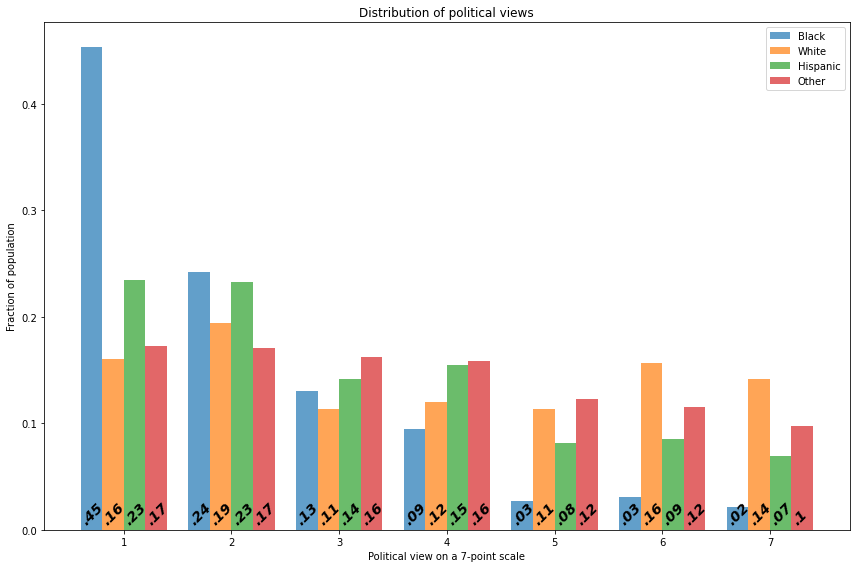

In [131]:
figure(figsize=(12, 8))
pmfComparison([black, white, hispanic, other], fontsize=14, xOffset=.08)
decorate(xlabel='Political view on a 7-point scale',
         ylabel='Fraction of population',
         title='Distribution of political views')

Just as a refresher, 4 is the center, 1 is the most democrat, and 7 is the most republican:

1. Strong Democrat
2. Weak Democrat
3. Independent -Democrat
4. Independent -Independent
5. Independent -Republican
6. Weak Republican
7. Strong Republican



Now let's reduce the number of categories to see if we can see anything else. Let's look at this on the three point scale (1-3 democrats, 4 independents, 5-7 republicans.

In [132]:
black3 = data[data['race']=='black']['pol']
black3.name = 'Black'
white3 = data[data['race']=='white']['pol']
white3.name = 'White'
hispanic3 = data[data['race']=='hispanic']['pol']
hispanic3.name = 'Hispanic'
other3 = data[data['race']=='other']['pol']
other3.name = 'Other'

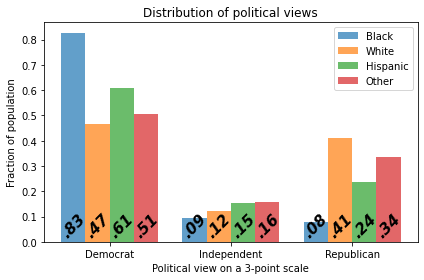

In [133]:
pmfComparison([black3, white3, hispanic3, other3], tick_label = ['Democrat', 'Independent', 'Republican'], xOffset=0.08)
decorate(xlabel='Political view on a 3-point scale',ylabel='Fraction of population', title='Distribution of political views')

Now it is quite a bit easier to see that women tend to lean democrat, and men tend to lean republican. There are about 5 percentage points more women democrats than men democrats. There are about 4 percentage points more men republicans than women republicans.

## Socio Economic Status

Let's grab the political affiliation for people of different socio economic statuses:

In [134]:
lower = data[data['income']=='lower']['pol']
lower.name = 'Lower'

lowerMiddle = data[data['income']=='lowerMiddle']['pol']
lowerMiddle.name = 'Lower Middle'

middle = data[data['income']=='middle']['pol']
middle.name = 'Middle'

upperMiddle = data[data['income']=='upperMiddle']['pol']
upperMiddle.name = 'Upper Middle'

upper = data[data['income']=='upper']['pol']
upper.name = 'Upper'

Here is the translation guide from class label to income percentile:

Class Label | Percentile
--- | ---
Lower | 0 to 16 percentile
Lower Middle | 17 to 33 percentile
Middle | 34 to 67 percentile
Upper Middle | 68 to 95 percentile
Upper | 96 to 100 percentile

Now for the visualization of political affiliation by socio economic status:

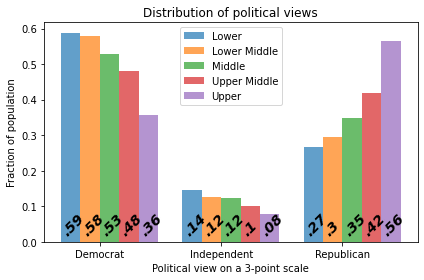

In [135]:
pmfComparison([lower, lowerMiddle, middle, upperMiddle, upper], tick_label = ['Democrat', 'Independent', 'Republican'], fontsize=14, xOffset=0.09)
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title='Distribution of political views')

ANALYSIS

## Age

Let's grab the age groups of different respondents:

In [136]:
values(age)

17-24     5630
25-34    12241
35-44    11838
45-54    10106
55-64     8970
65-74     6787
75-99     3818
Name: age, dtype: int64

In [137]:
ageOne = data[data['age']=='17-24']['pol']
ageOne.name = '17-24'

ageTwo = data[data['age']=='25-34']['pol']
ageTwo.name = '25-34'

ageThree = data[data['age']=='35-44']['pol']
ageThree.name = '35-44'

ageFour = data[data['age']=='45-54']['pol']
ageFour.name = '45-54'

ageFive = data[data['age']=='55-64']['pol']
ageFive.name = '55-64'

ageSix = data[data['age']=='65-74']['pol']
ageSix.name = '65-74'

ageSeven = data[data['age']=='75-99']['pol']
ageSeven.name = '75-99'

Now for the visualization of political affiliation by socio economic status:

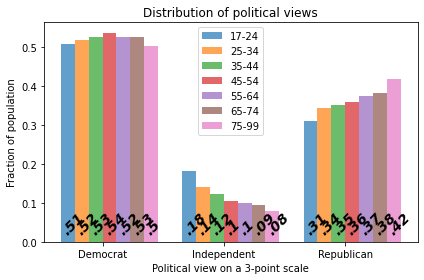

In [138]:
pmfComparison([ageOne, ageTwo, ageThree, ageFour, ageFive, ageSix, ageSeven], tick_label = ['Democrat', 'Independent', 'Republican'], fontsize=14, xOffset=0.09)
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title='Distribution of political views')

## Education

Let's grab the political affiliation for people of different socio economic statuses:

In [139]:
values(educ)

College Degree    12011
Grade School       8098
High School       25884
Some College      13360
Name: educ, dtype: int64

In [140]:
grade = data[data['educ']=='Grade School']['pol']
grade.name = 'Grade School'

high = data[data['educ']=='High School']['pol']
high.name = 'High School'

someCollege = data[data['educ']=='Some College']['pol']
someCollege.name = 'Some College'

college = data[data['educ']=='College Degree']['pol']
college.name = 'College Degree'

Now for the visualization of political affiliation by education:

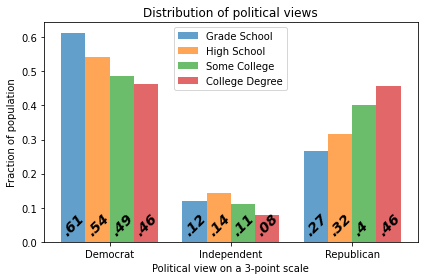

In [141]:
pmfComparison([grade, high, someCollege, college], tick_label = ['Democrat', 'Independent', 'Republican'], fontsize=14, xOffset=0.09)
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title='Distribution of political views')

## Father Political Affiliation

Let's grab the political affiliation of different father's of interviewees:

In [142]:
dadDemo = data[data['fatherPol']=='Democrat']['pol']
dadDemo.name = 'Democrat Father'

dadInde = data[data['fatherPol']=='Independent']['pol']
dadInde.name = 'Independent Father'

dadRepu = data[data['fatherPol']=='Republican']['pol']
dadRepu.name = 'Republican Father'

Now for the visualization of political affiliation by socio economic status:

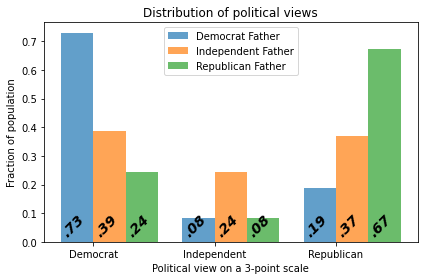

In [143]:
pmfComparison([dadDemo, dadInde, dadRepu], tick_label = ['Democrat', 'Independent', 'Republican'], fontsize=14, xOffset=0.09)
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title='Distribution of political views')

ANALYSIS

## Mother Political Affiliation

Let's grab the political affiliation of different mother's of interviewees:

In [144]:
momDemo = data[data['motherPol']=='Democrat']['pol']
momDemo.name = 'Democrat Mother'

momInde = data[data['motherPol']=='Independent']['pol']
momInde.name = 'Independent Mother'

momRepu = data[data['motherPol']=='Republican']['pol']
momRepu.name = 'Republican Mother'

Now for the visualization of political affiliation by socio economic status:

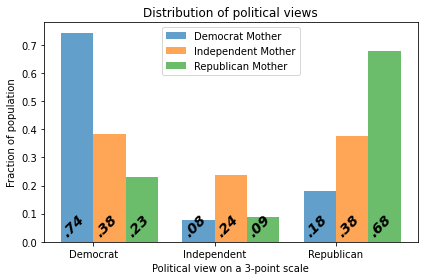

In [145]:
pmfComparison([momDemo, momInde, momRepu], tick_label = ['Democrat', 'Independent', 'Republican'], fontsize=14, xOffset=0.09)
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title='Distribution of political views')

ANALYSIS

# Notes
* CDF could be useful (see notebook 8)
* Regressions (notebook 10)
* Plotting pol views over time (mini project 2)
* Should probably have one thing over time for gender
* Right now we are ignoring shifts over time
* Grouping into three political parties: lean towards top two, bottom two, middle 3
* VCF0305 - Party identifiaction of respondent (strength of partisanship)
* Year vs party affiliation